# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=55,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_16-08-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4609 | MulticlassF1Score=0.1944
Batch-30 : CrossEntropyLoss=2.4792 | MulticlassF1Score=0.2229
Batch-45 : CrossEntropyLoss=2.4494 | MulticlassF1Score=0.2630
Batch-60 : CrossEntropyLoss=2.4618 | MulticlassF1Score=0.2897
Batch-75 : CrossEntropyLoss=2.4067 | MulticlassF1Score=0.3183
Batch-90 : CrossEntropyLoss=2.4114 | MulticlassF1Score=0.3510
Batch-105: CrossEntropyLoss=2.4244 | MulticlassF1Score=0.3760
Batch-120: CrossEntropyLoss=2.3663 | MulticlassF1Score=0.3979
Batch-135: CrossEntropyLoss=2.3774 | MulticlassF1Score=0.4201
Batch-150: CrossEntropyLoss=2.3665 | MulticlassF1Score=0.4395
Batch-165: CrossEntropyLoss=2.3637 | MulticlassF1Score=0.4594
Batch-180: CrossEntropyLoss=2.3603 | MulticlassF1Score=0.4768
Batch-195: CrossEntropyLoss=2.3508 | MulticlassF1Score=0.4913
Batch-210: CrossEntropyLoss=2.3486 | MulticlassF1Score=0.5041
Batch-225: CrossEntropyLoss=2.3443 | MulticlassF1Score=0.5155
Batch-226: CrossEntropyLoss=2.3637 | MulticlassF1Score=0.5159

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3540 | MulticlassF1Score=0.6763
Batch-30 : CrossEntropyLoss=2.3700 | MulticlassF1Score=0.6700
Batch-45 : CrossEntropyLoss=2.3300 | MulticlassF1Score=0.6760
Batch-60 : CrossEntropyLoss=2.3306 | MulticlassF1Score=0.6782
Batch-63 : CrossEntropyLoss=2.3221 | MulticlassF1Score=0.6783

Training   : Mean CrossEntropyLoss = 2.4096 | Mean MulticlassF1Score = 0.3703
Validation : Mean CrossEntropyLoss = 2.3477 | Mean MulticlassF1Score = 0.6738

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3567 | MulticlassF1Score=0.6653
Batch-30 : CrossEntropyLoss=2.3584 | MulticlassF1Score=0.6679
Batch-45 : CrossEntropyLoss=2.3416 | MulticlassF1Score=0.6731
Batch-60 : CrossEntropyLoss=2.3486 | MulticlassF1Score=0.6753
Batch-75 : CrossEntropyLoss=2.3526 | MulticlassF1Score=0.6758
Batch-90 : CrossEntropyLoss=2.3558 | MulticlassF1Score=0.6760
Batch-105: CrossEntropyLoss=2.3290 | MulticlassF1Score=0.6793
Batch-120: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.6887
Batch-135: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.6985
Batch-150: CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7066
Batch-165: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7137
Batch-180: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7203
Batch-195: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7254
Batch-210: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7296
Batch-225: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7334
Batch-226: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7336

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7907
Batch-30 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7916
Batch-45 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7906
Batch-60 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7902
Batch-63 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3313 | Mean MulticlassF1Score = 0.6941
Validation : Mean CrossEntropyLoss = 2.3132 | Mean MulticlassF1Score = 0.7900

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.7919
Batch-30 : CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7908
Batch-45 : CrossEntropyLoss=2.3320 | MulticlassF1Score=0.7900
Batch-60 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7900
Batch-75 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.7929
Batch-90 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7965
Batch-105: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7994
Batch-120: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8015
Batch-135: CrossEntropyLoss=2.3165 | MulticlassF1Score=0.8023
Batch-150: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8031
Batch-165: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8038
Batch-180: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8049
Batch-195: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8057
Batch-210: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8065
Batch-225: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8064
Batch-226: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8065

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8218
Batch-30 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8219
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8220
Batch-60 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8235
Batch-63 : CrossEntropyLoss=2.3181 | MulticlassF1Score=0.8233

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3081 | Mean MulticlassF1Score = 0.7988
Validation : Mean CrossEntropyLoss = 2.3039 | Mean MulticlassF1Score = 0.8234

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8297
Batch-30 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8294
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8269
Batch-60 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8276
Batch-75 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8267
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8277
Batch-105: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8278
Batch-120: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8276
Batch-135: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8272
Batch-150: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8271
Batch-165: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8274
Batch-180: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8278
Batch-195: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8275
Batch-210: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8273
Batch-225: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8274
Batch-226: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8275

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8289
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8269
Batch-45 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.8269
Batch-60 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8274
Batch-63 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8277
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8280

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8239
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8238
Batch-45 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8261
Batch-60 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8279
Batch-75 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8262
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8264
Batch-105: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8277
Batch-120: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8296
Batch-135: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8302
Batch-150: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8310
Batch-165: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8315
Batch-180: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8324
Batch-195: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8326
Batch-210: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8335
Batch-225: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8341
Batch-226: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8342

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8372
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8361
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8360
Batch-60 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8359
Batch-63 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8363

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2992 | Mean MulticlassF1Score = 0.8285
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8379

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8410
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8415
Batch-45 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8420
Batch-60 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8421
Batch-75 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8426
Batch-90 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8420
Batch-105: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8413
Batch-120: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8406
Batch-135: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8404
Batch-150: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8407
Batch-165: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8415
Batch-180: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8416
Batch-195: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8418
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8410
Batch-225: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8409
Batch-226: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8364
Batch-30 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8369
Batch-45 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8375
Batch-63 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8380

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8409
Validation : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8363

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8487
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8470
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8469
Batch-60 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8502
Batch-75 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8510
Batch-90 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8516
Batch-105: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8524
Batch-120: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8525
Batch-135: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8536
Batch-150: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8535
Batch-165: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8543
Batch-180: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8545
Batch-195: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8552
Batch-210: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8551
Batch-225: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8550
Batch-226: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8551

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8523
Batch-30 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8549
Batch-45 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8556
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8550
Batch-63 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8550

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2928 | Mean MulticlassF1Score = 0.8518
Validation : Mean CrossEntropyLoss = 2.2929 | Mean MulticlassF1Score = 0.8552

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8598
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8557
Batch-45 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8568
Batch-60 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8581
Batch-75 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8588
Batch-90 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8591
Batch-105: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8590
Batch-120: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8595
Batch-135: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8598
Batch-150: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8600
Batch-165: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8605
Batch-180: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8604
Batch-195: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8607
Batch-210: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8602
Batch-225: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8603
Batch-226: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8603

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8595
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8612
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8622
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8622
Batch-63 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8620

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2911 | Mean MulticlassF1Score = 0.8591
Validation : Mean CrossEntropyLoss = 2.2908 | Mean MulticlassF1Score = 0.8613

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8824
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8855
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8850
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8858
Batch-75 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8861
Batch-90 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8860
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8861
Batch-120: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8866
Batch-135: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8864
Batch-150: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8864
Batch-165: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8870
Batch-180: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8868
Batch-195: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8868
Batch-210: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8870
Batch-225: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8870
Batch-226: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8870

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8816
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8843
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8823
Batch-60 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8826
Batch-63 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8825

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8858
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8805

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8934
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8923
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8917
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8921
Batch-105: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8922
Batch-120: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8923
Batch-135: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8921
Batch-150: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8919
Batch-165: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8917
Batch-180: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8918
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8921
Batch-210: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8921
Batch-225: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8922
Batch-226: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8922

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8802
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8821
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8836
Batch-60 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8841
Batch-63 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8846

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8918
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8809

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8936
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8955
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9004
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9038
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9066
Batch-90 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9076
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9091
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9104
Batch-135: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9109
Batch-150: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9115
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9122
Batch-180: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9129
Batch-195: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9136
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9139
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9141
Batch-226: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9142

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9122
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9115
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9114
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9114
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9116

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9070
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9122

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9217
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9234
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9215
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9222
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9228
Batch-105: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9230
Batch-120: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9230
Batch-135: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9232
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9233
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9236
Batch-180: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9237
Batch-195: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9232
Batch-210: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9230
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9230
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9230

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9132
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9131
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9152
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9141
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9142

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9225
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9136

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9230
Batch-75 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9239
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9244
Batch-105: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9246
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9245
Batch-135: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9247
Batch-150: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9246
Batch-165: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9246
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9245
Batch-195: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9246
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9247
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9251
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9252

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9157
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9166
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9158
Batch-63 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9154

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9244
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9155

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9297
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9274
Batch-45 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9279
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9272
Batch-90 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9267
Batch-105: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9265
Batch-120: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9267
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9269
Batch-150: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9274
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9271
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9271
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9273
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9273
Batch-225: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9271
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9272

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9169
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9164
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9152
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9156

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9273
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9164

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9271
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9264
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9275
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9282
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9283
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9283
Batch-165: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9282
Batch-180: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9285
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9285
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9285
Batch-225: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9283
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9283

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9149
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9153
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9160
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9161

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9278
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9166

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9289
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9292
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9299
Batch-105: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9302
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9299
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9299
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9299
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9299
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9299
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9292
Batch-210: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9291
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9292
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9292

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9161
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9163

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9292
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9160

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9295
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9288
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9297
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9299
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9297
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9295
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9293
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9296
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9297
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9296
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9300
Batch-210: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9298
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9300
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9124
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9142
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9160
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9160

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9295
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9133

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9322
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9304
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9316
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9305
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9310
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9300
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9303
Batch-135: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9300
Batch-150: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9303
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9304
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9305
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9304
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9302
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9301
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9301

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9160
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9146
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9160
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9160

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9304
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9144

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9338
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9327
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9314
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9311
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9309
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9309
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9309
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9312
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9310
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9309
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9309
Batch-210: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9310
Batch-225: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9307
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9307

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9155
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9163
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9161
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9166

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9314
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9157

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9336
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9320
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9320
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9318
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9319
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9316
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9312
Batch-150: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9311
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9315
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9316
Batch-195: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9316
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9313
Batch-225: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9315
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9315

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9178
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9156
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9152
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9171
Batch-63 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9171

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9320
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9160

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9330
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9319
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9318
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9316
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9319
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9325
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9324
Batch-150: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9324
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9324
Batch-180: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9323
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9321
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9323
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9320
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9180
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9168
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9168
Batch-60 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9162
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9165

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9321
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9178

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9284
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9305
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9328
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9330
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9326
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9326
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9327
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9330
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9329
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9332
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9337
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9336
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9337

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9190
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9193

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9325
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9187

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9364
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9383
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9366
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9359
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9359
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9362
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9374
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9375
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9372
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9373
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9379
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9211

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9371
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9188

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9389
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9393
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9395
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9168
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9213
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9190

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9427
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9419
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9415
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9411
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9411
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9409
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9409
Batch-226: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9228
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9415
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9229

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9418
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9418
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9419
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9216

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9418
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9409
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9407
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9411
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9419

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9256

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9447
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9447
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9267

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9458
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9456
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9455
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9455

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9281

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9459
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9460
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9461
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9264

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9460
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9462
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9466
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9467
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9261

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9480
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9273

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9538
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9576
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9598
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9611
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9622
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9625
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9630
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9637
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9640
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9643
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9649
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9611
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9472

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9469

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9486

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9454

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9468

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9723
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9696
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9460

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9477

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9488
Patience = 1/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9485

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9477
Patience = 2/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9473

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9700
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9483

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9554
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9516

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9713
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9492

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9723
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9719
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9718
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9720
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9720

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9501

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9717
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9708
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2511 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9720
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9722

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9502

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9745
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9744
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9730
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9729
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9726
Batch-90 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9721
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9722
Batch-150: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9725
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9727
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9726
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9724
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9722
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9723
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9723

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9728
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9492

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9722
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9723
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9721
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9722
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9721
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9722
Batch-195: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9720
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9721
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9722
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9722

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9486

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9468
Patience = 3/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9714
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9491

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9498
Patience = 4/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9709
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9708
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9482

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9472
Patience = 5/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2559
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9728
Best MulticlassF1Score validation : 0.9492
Training duration                 : 2.4236 minutes.
Training date                     : 2022-10-19 11:01:31.813556+08:00


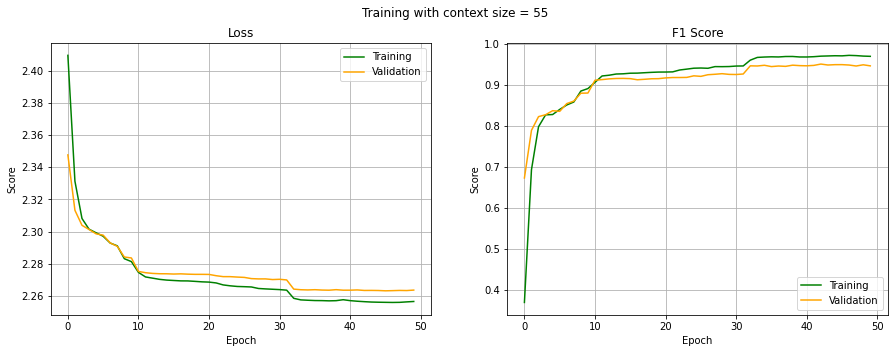

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9715, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9494, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9715, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9494, device='cuda:0'))

## Heatmap

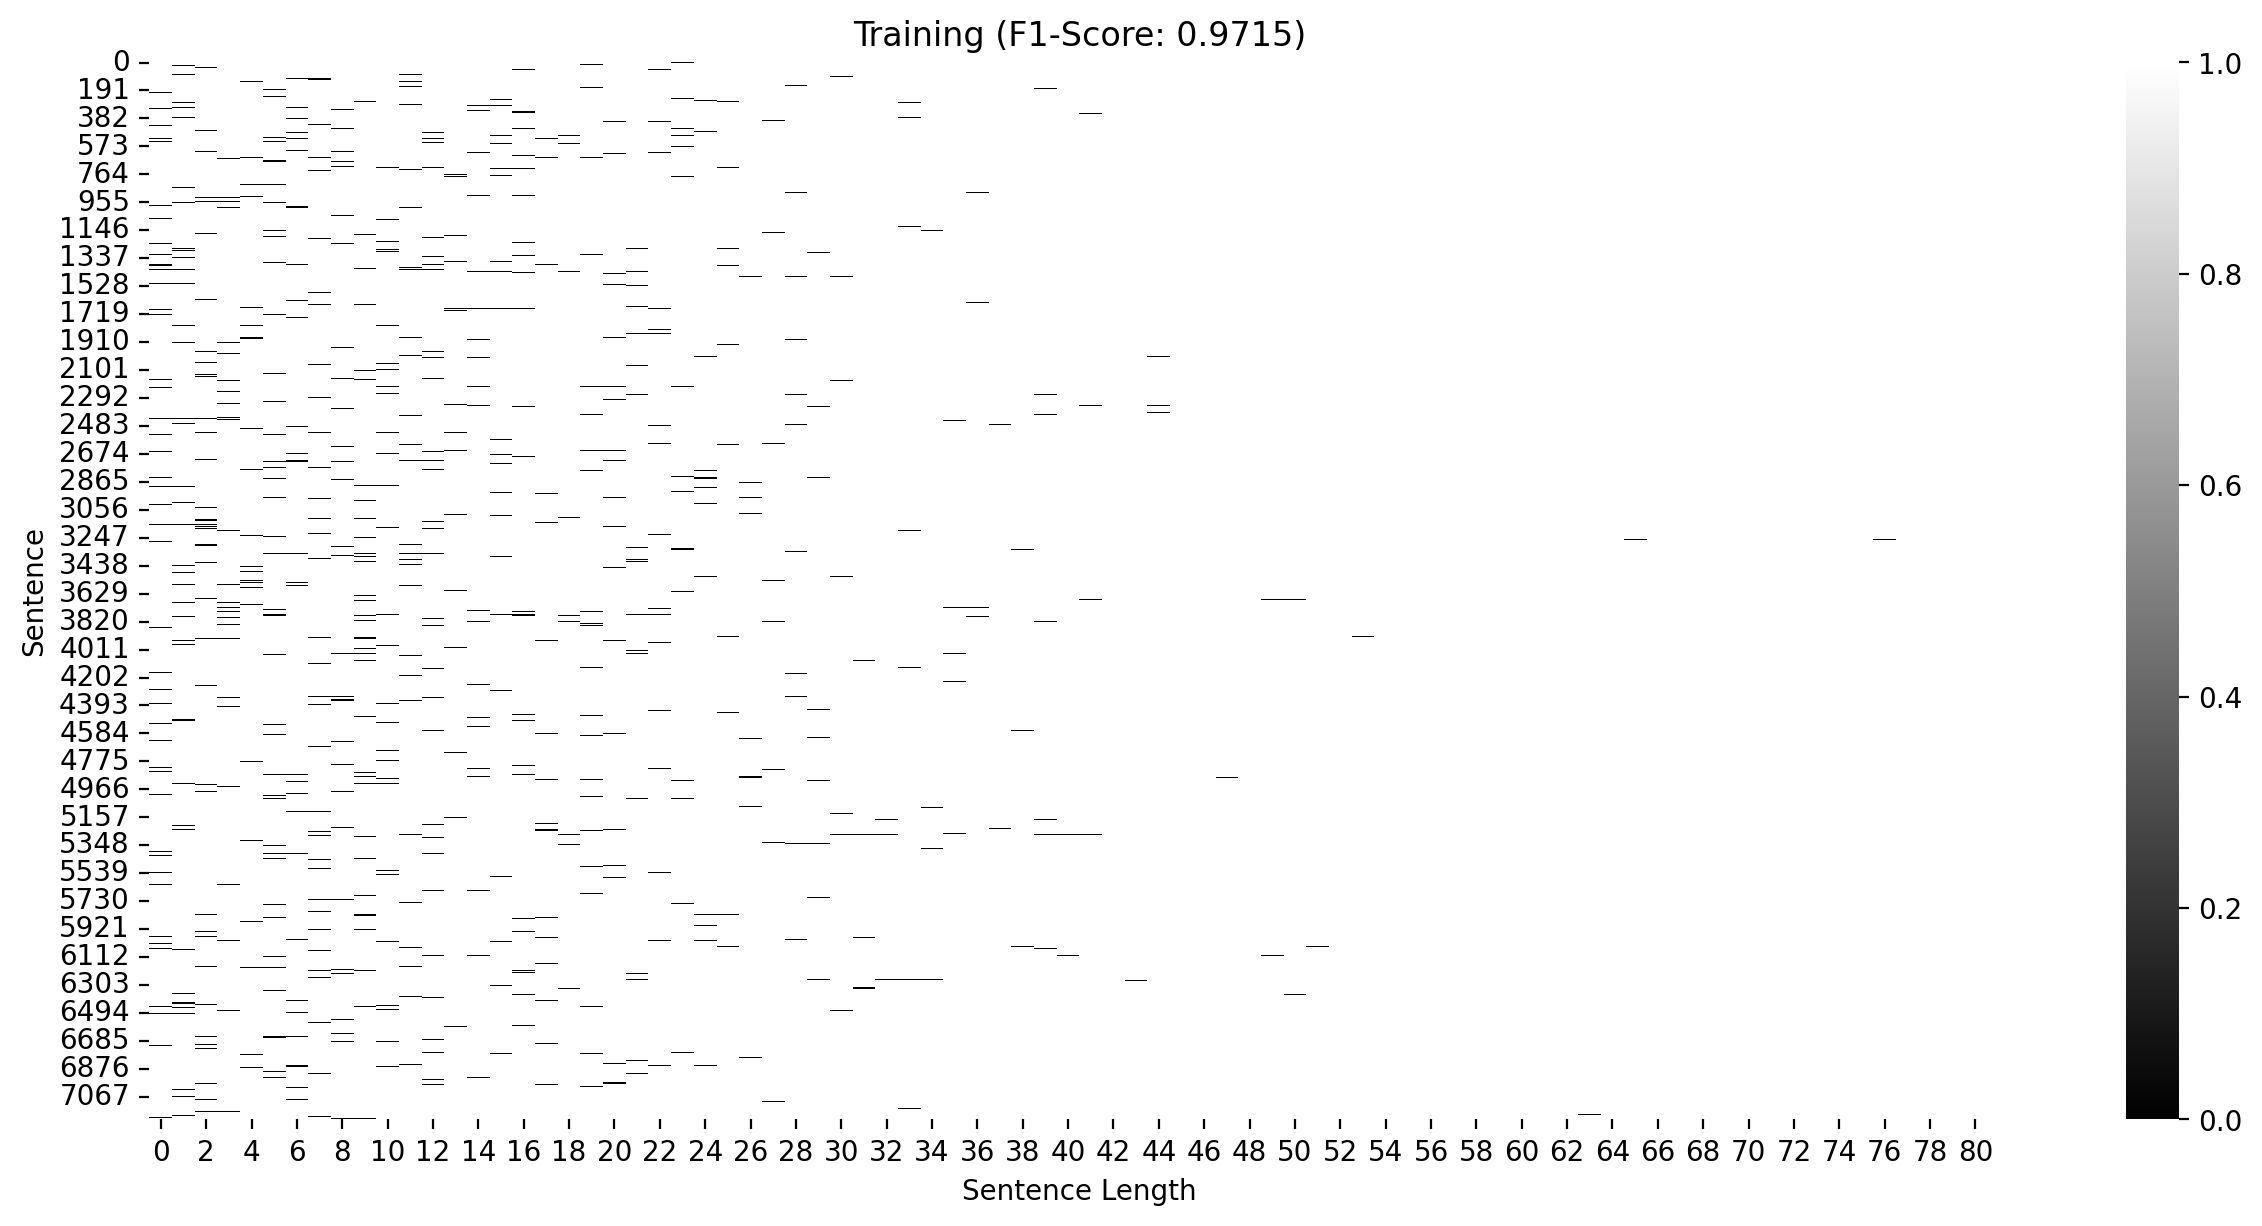

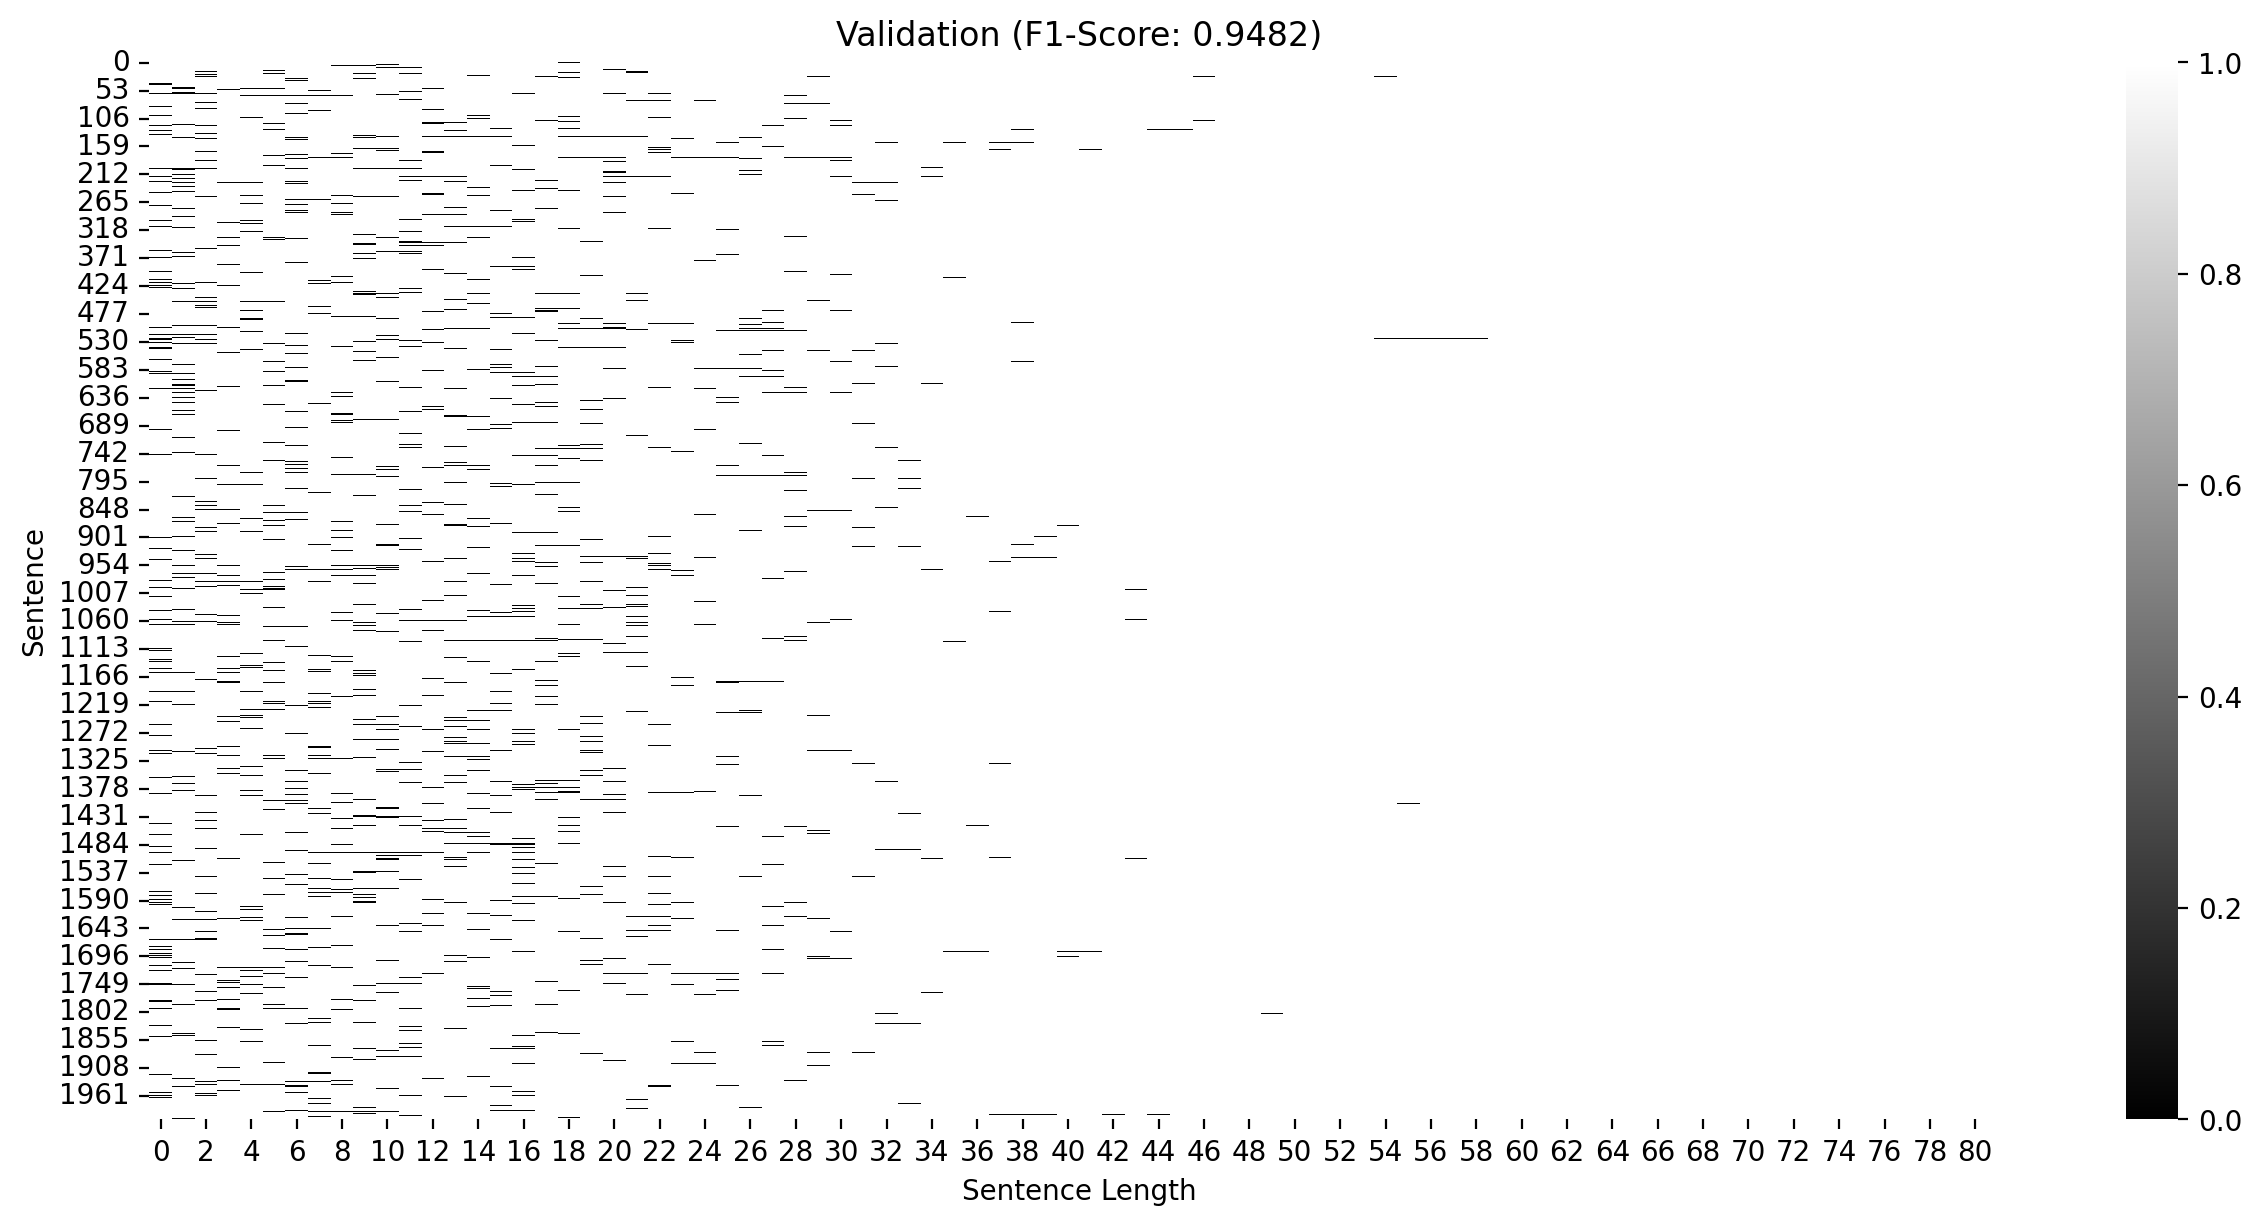

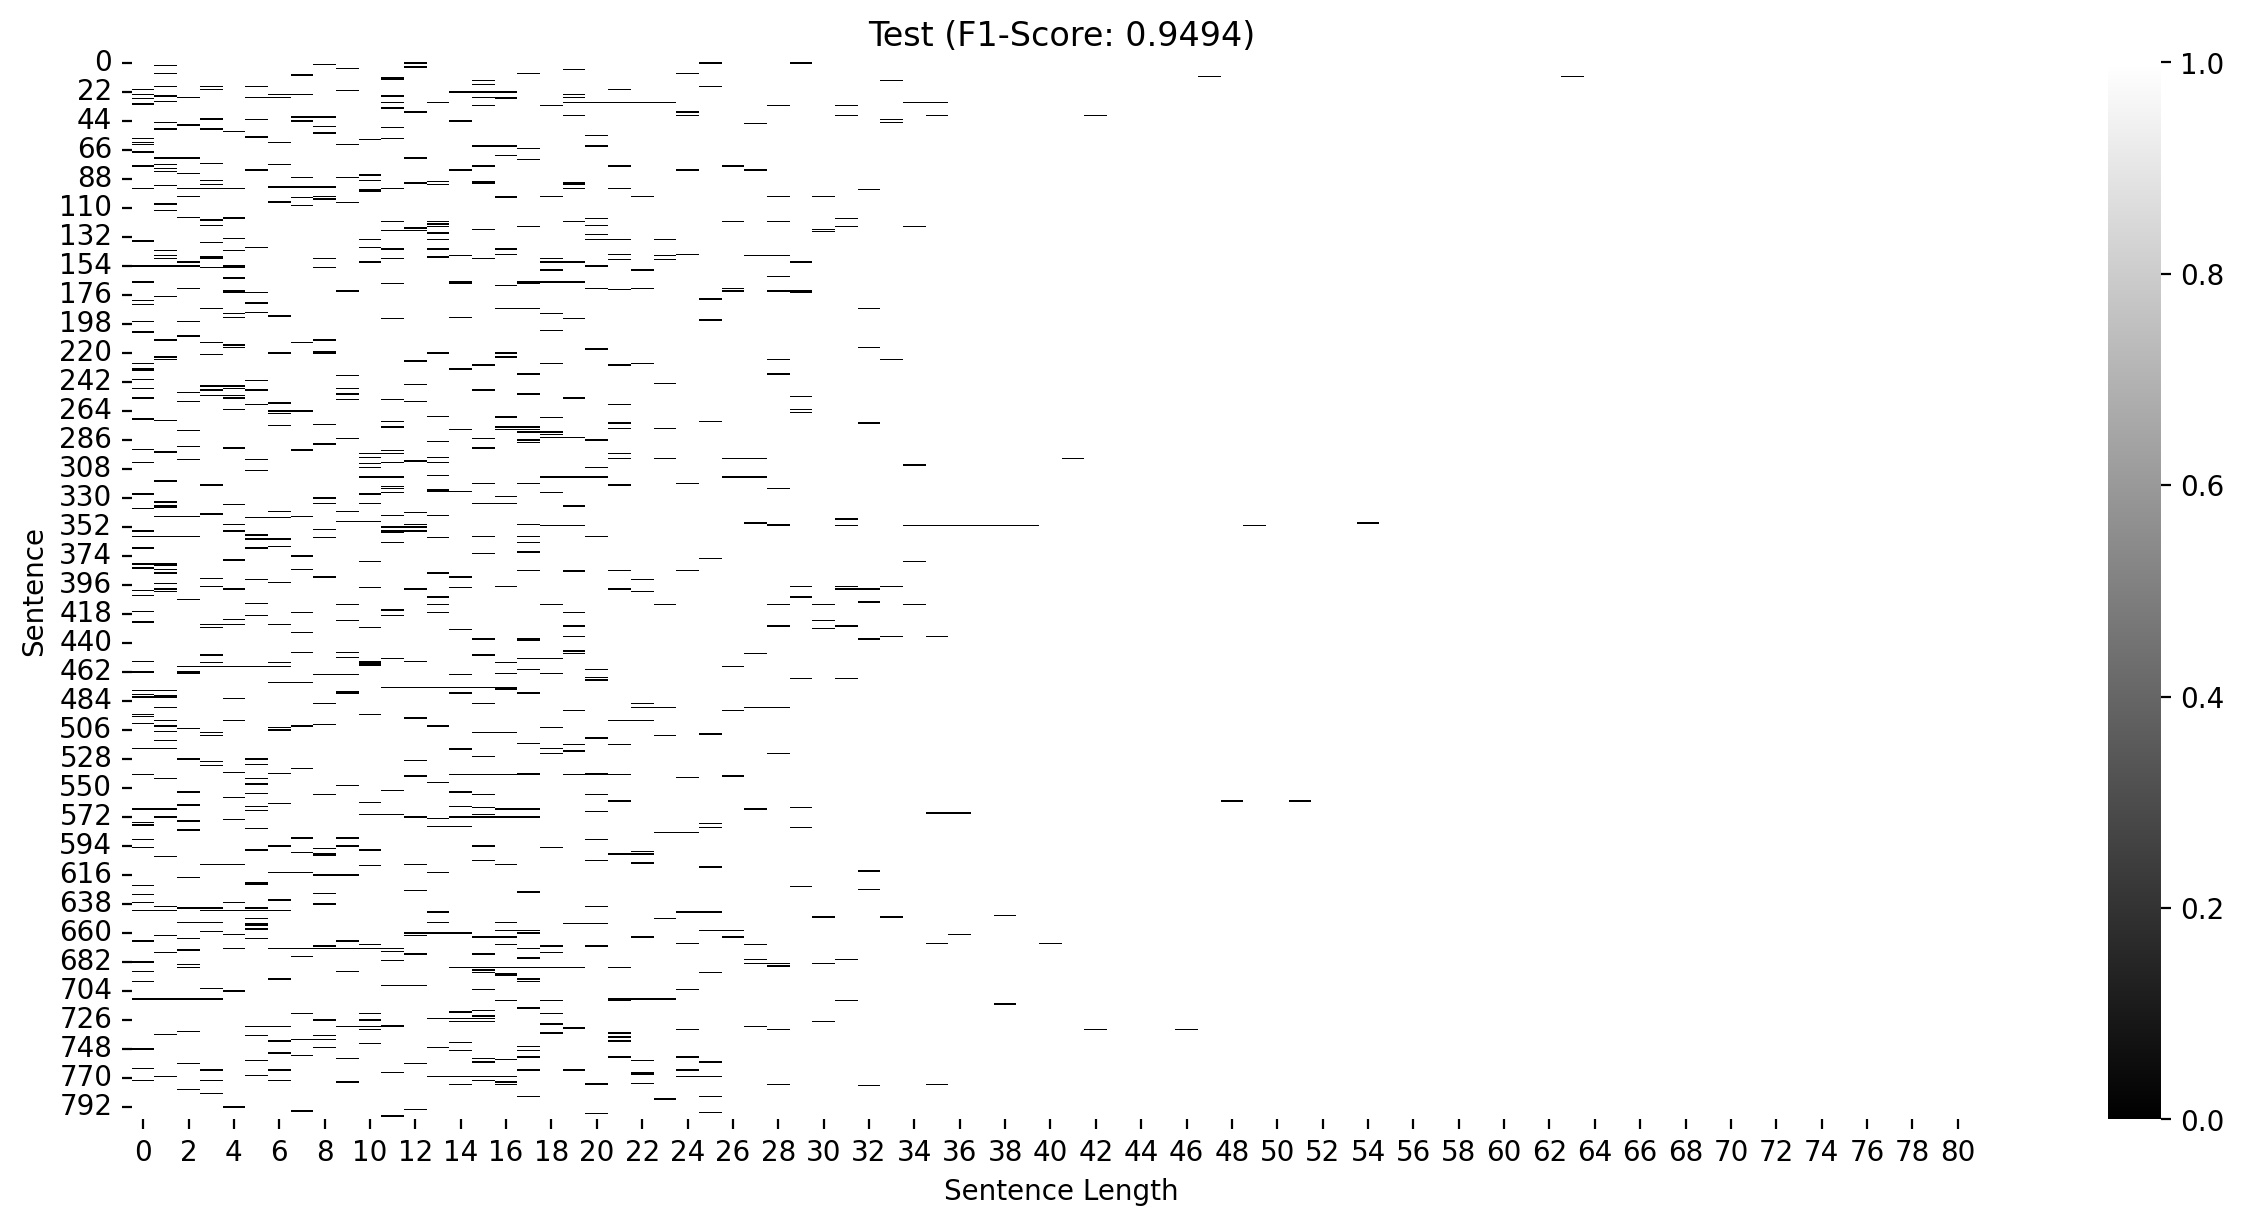

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


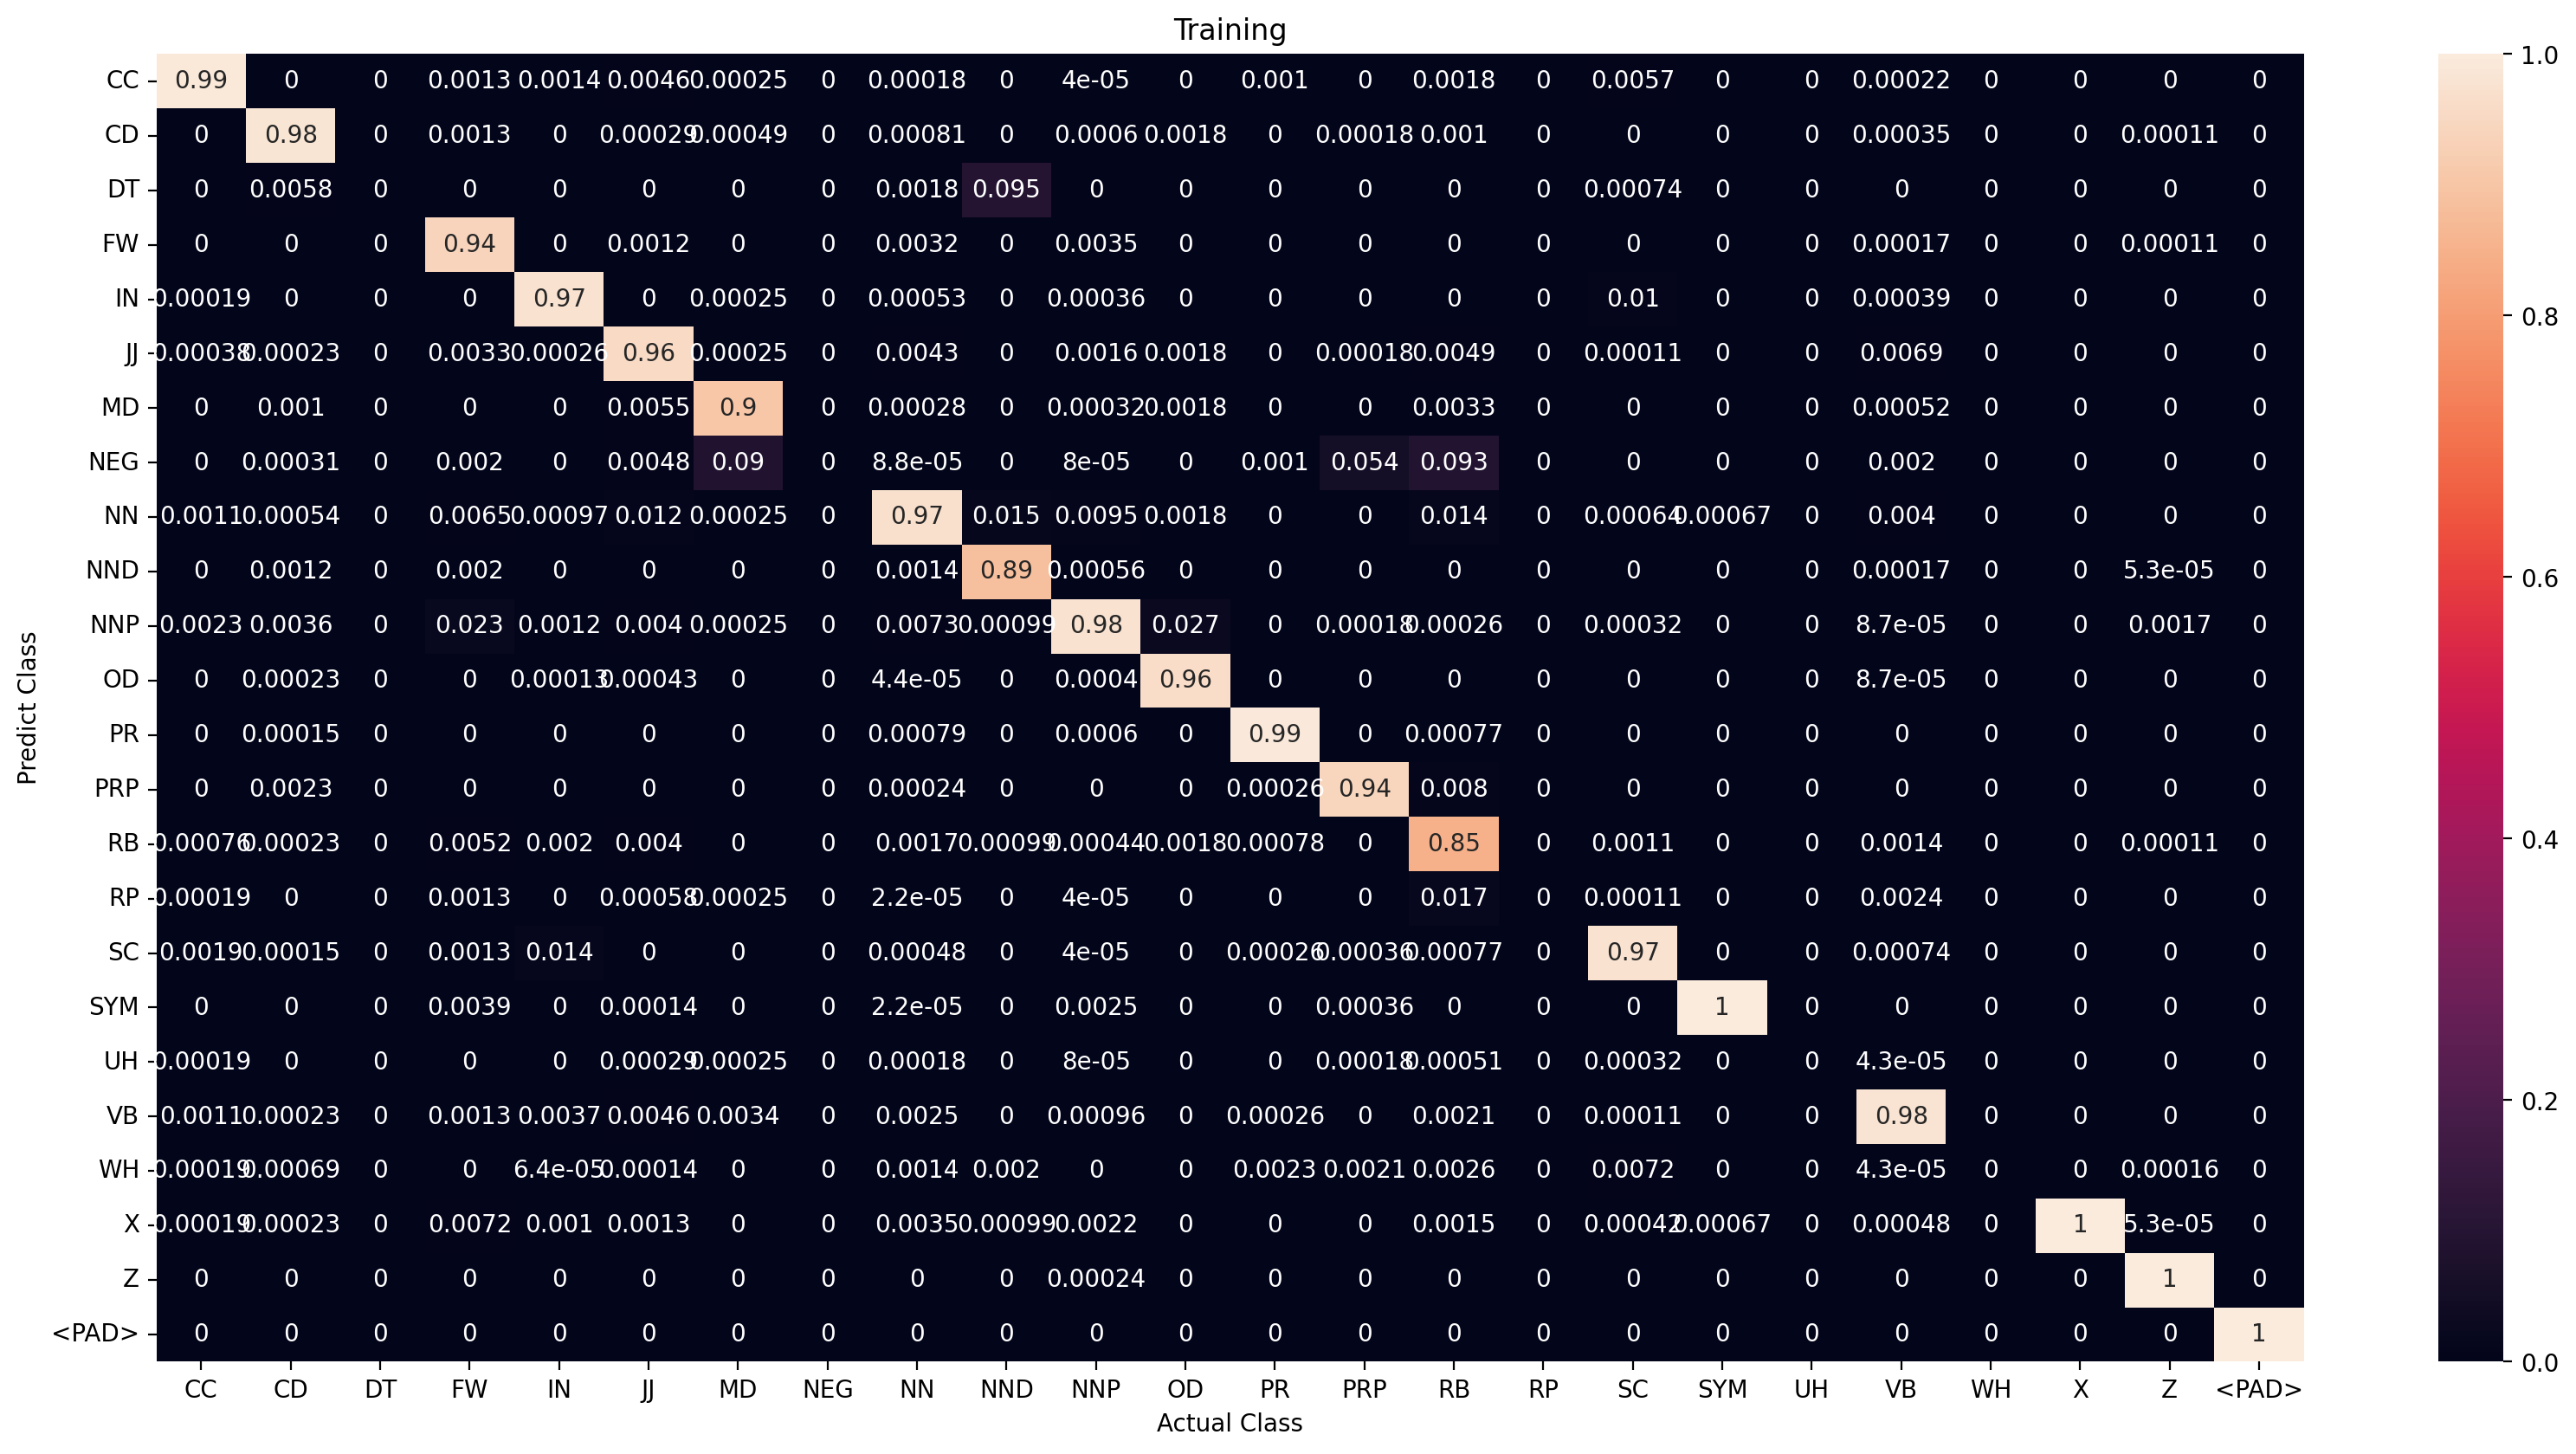

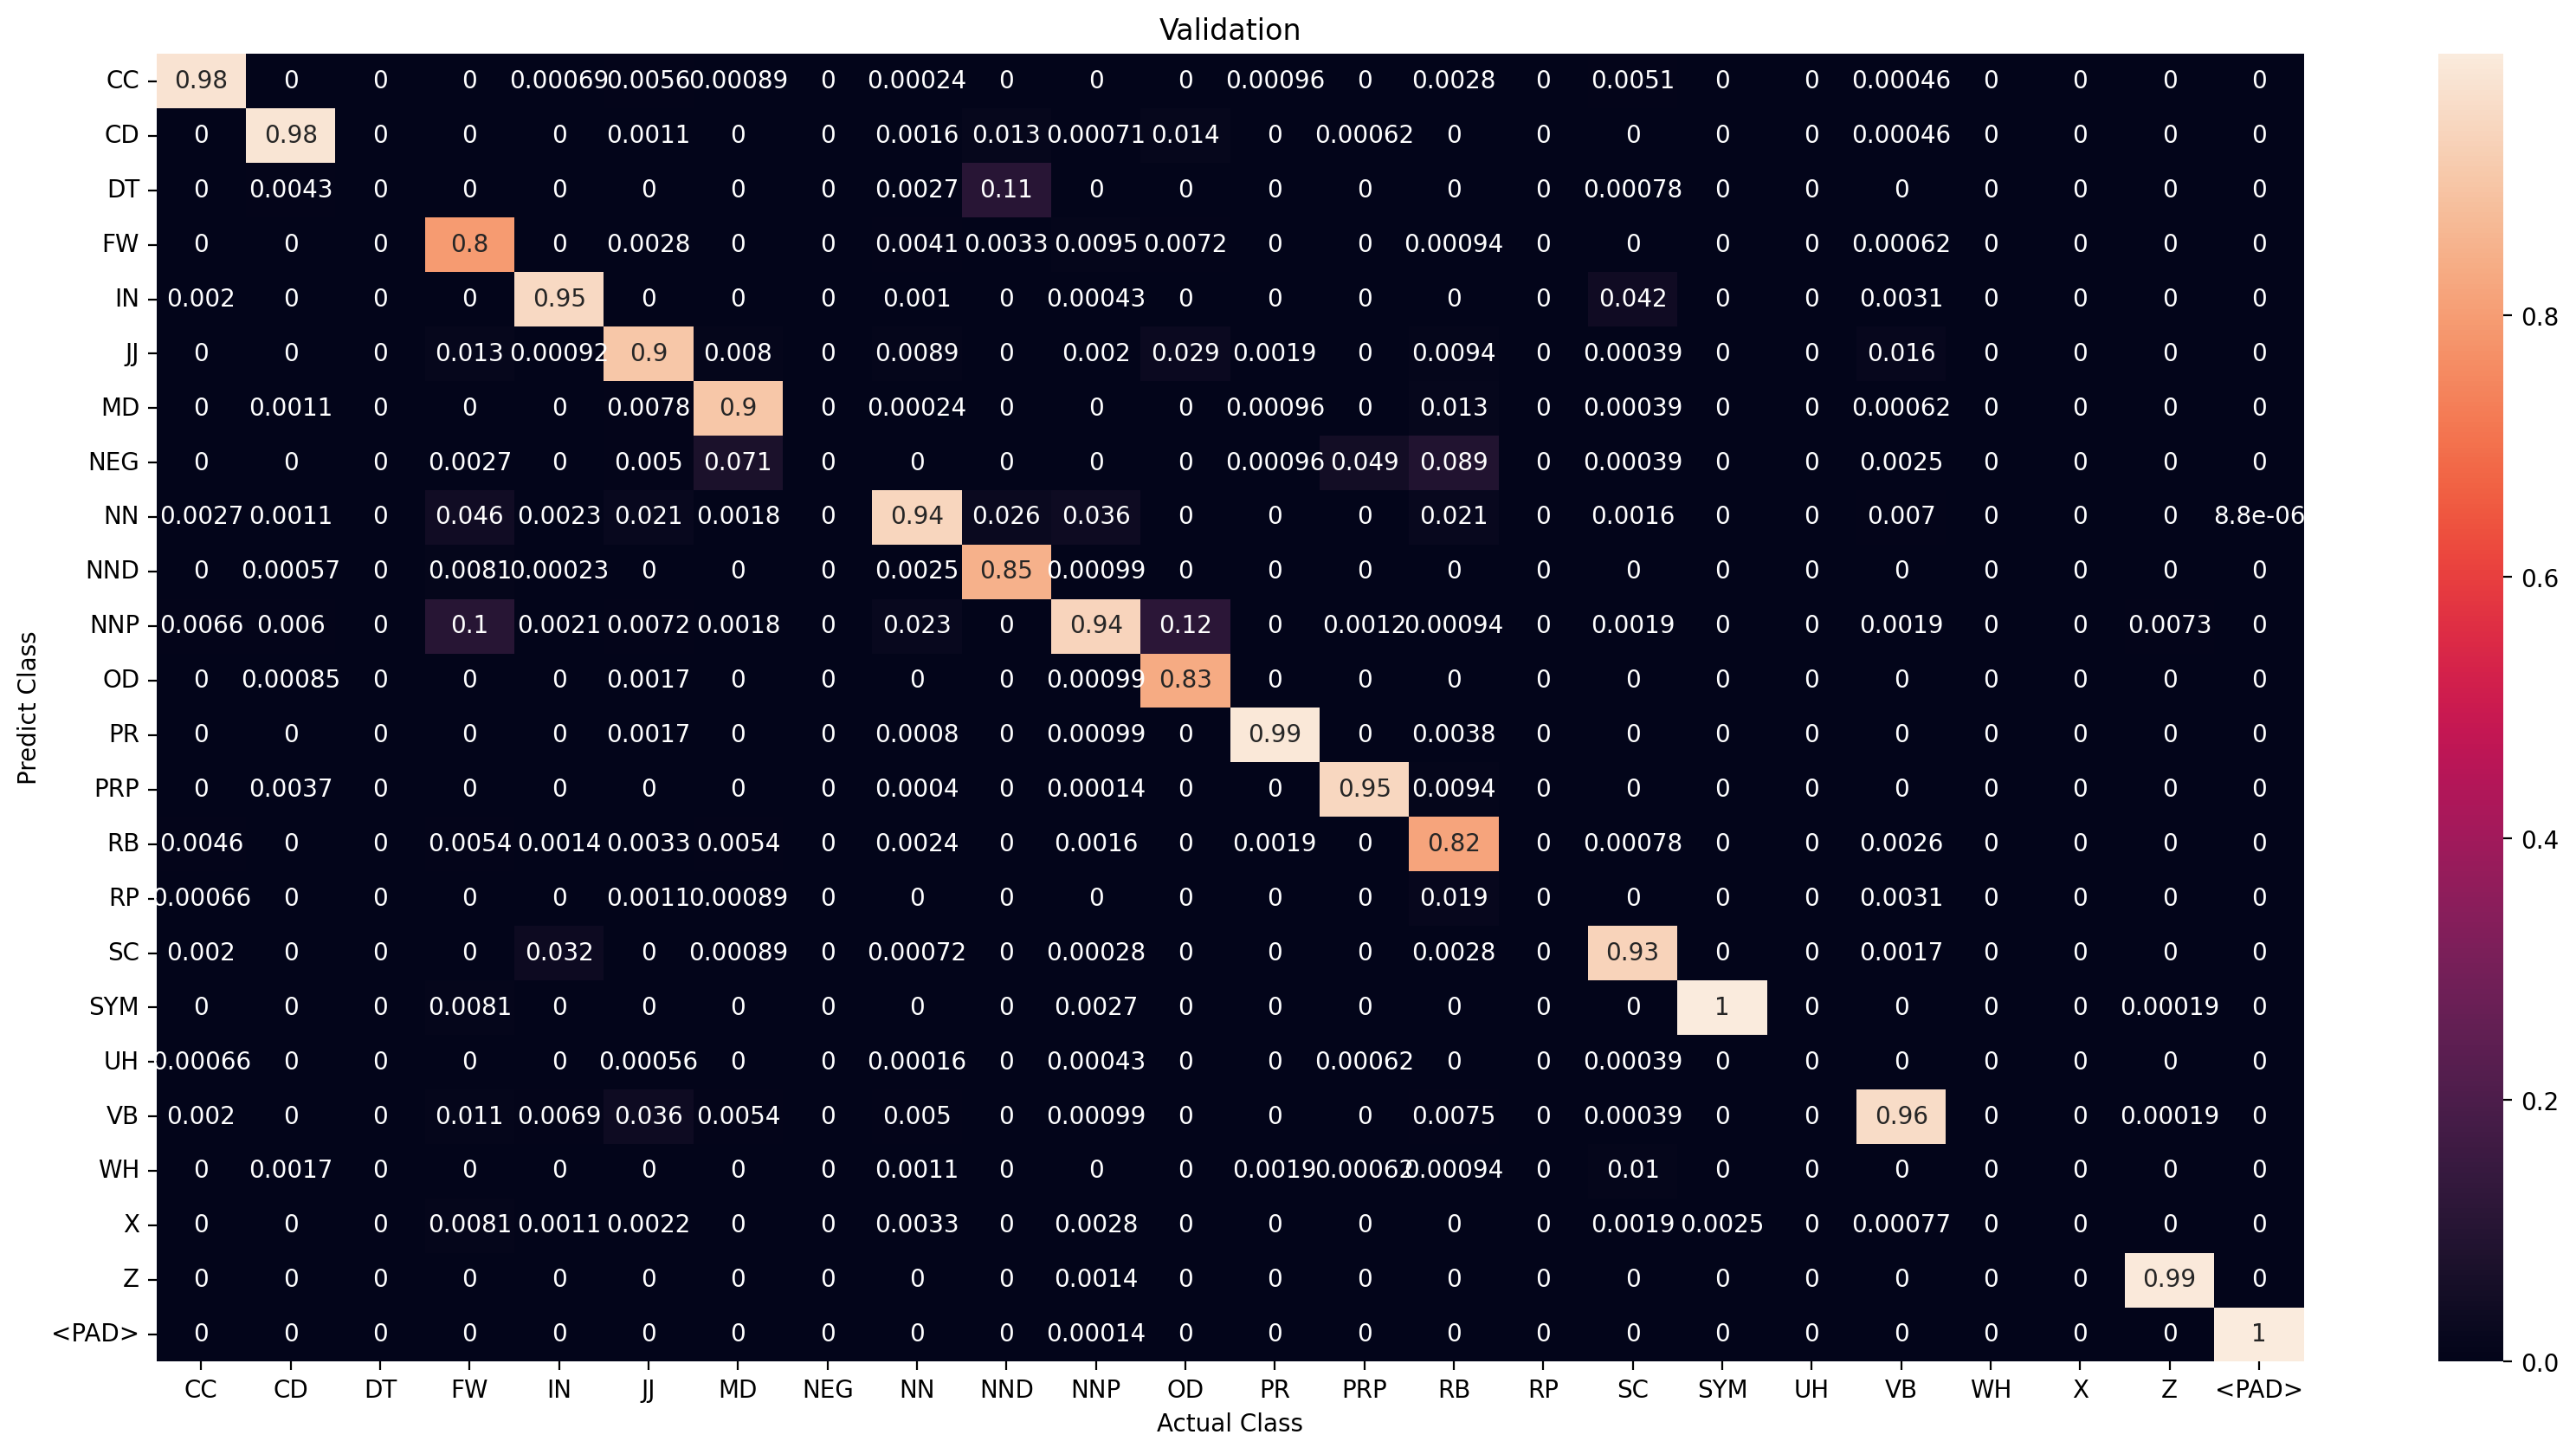

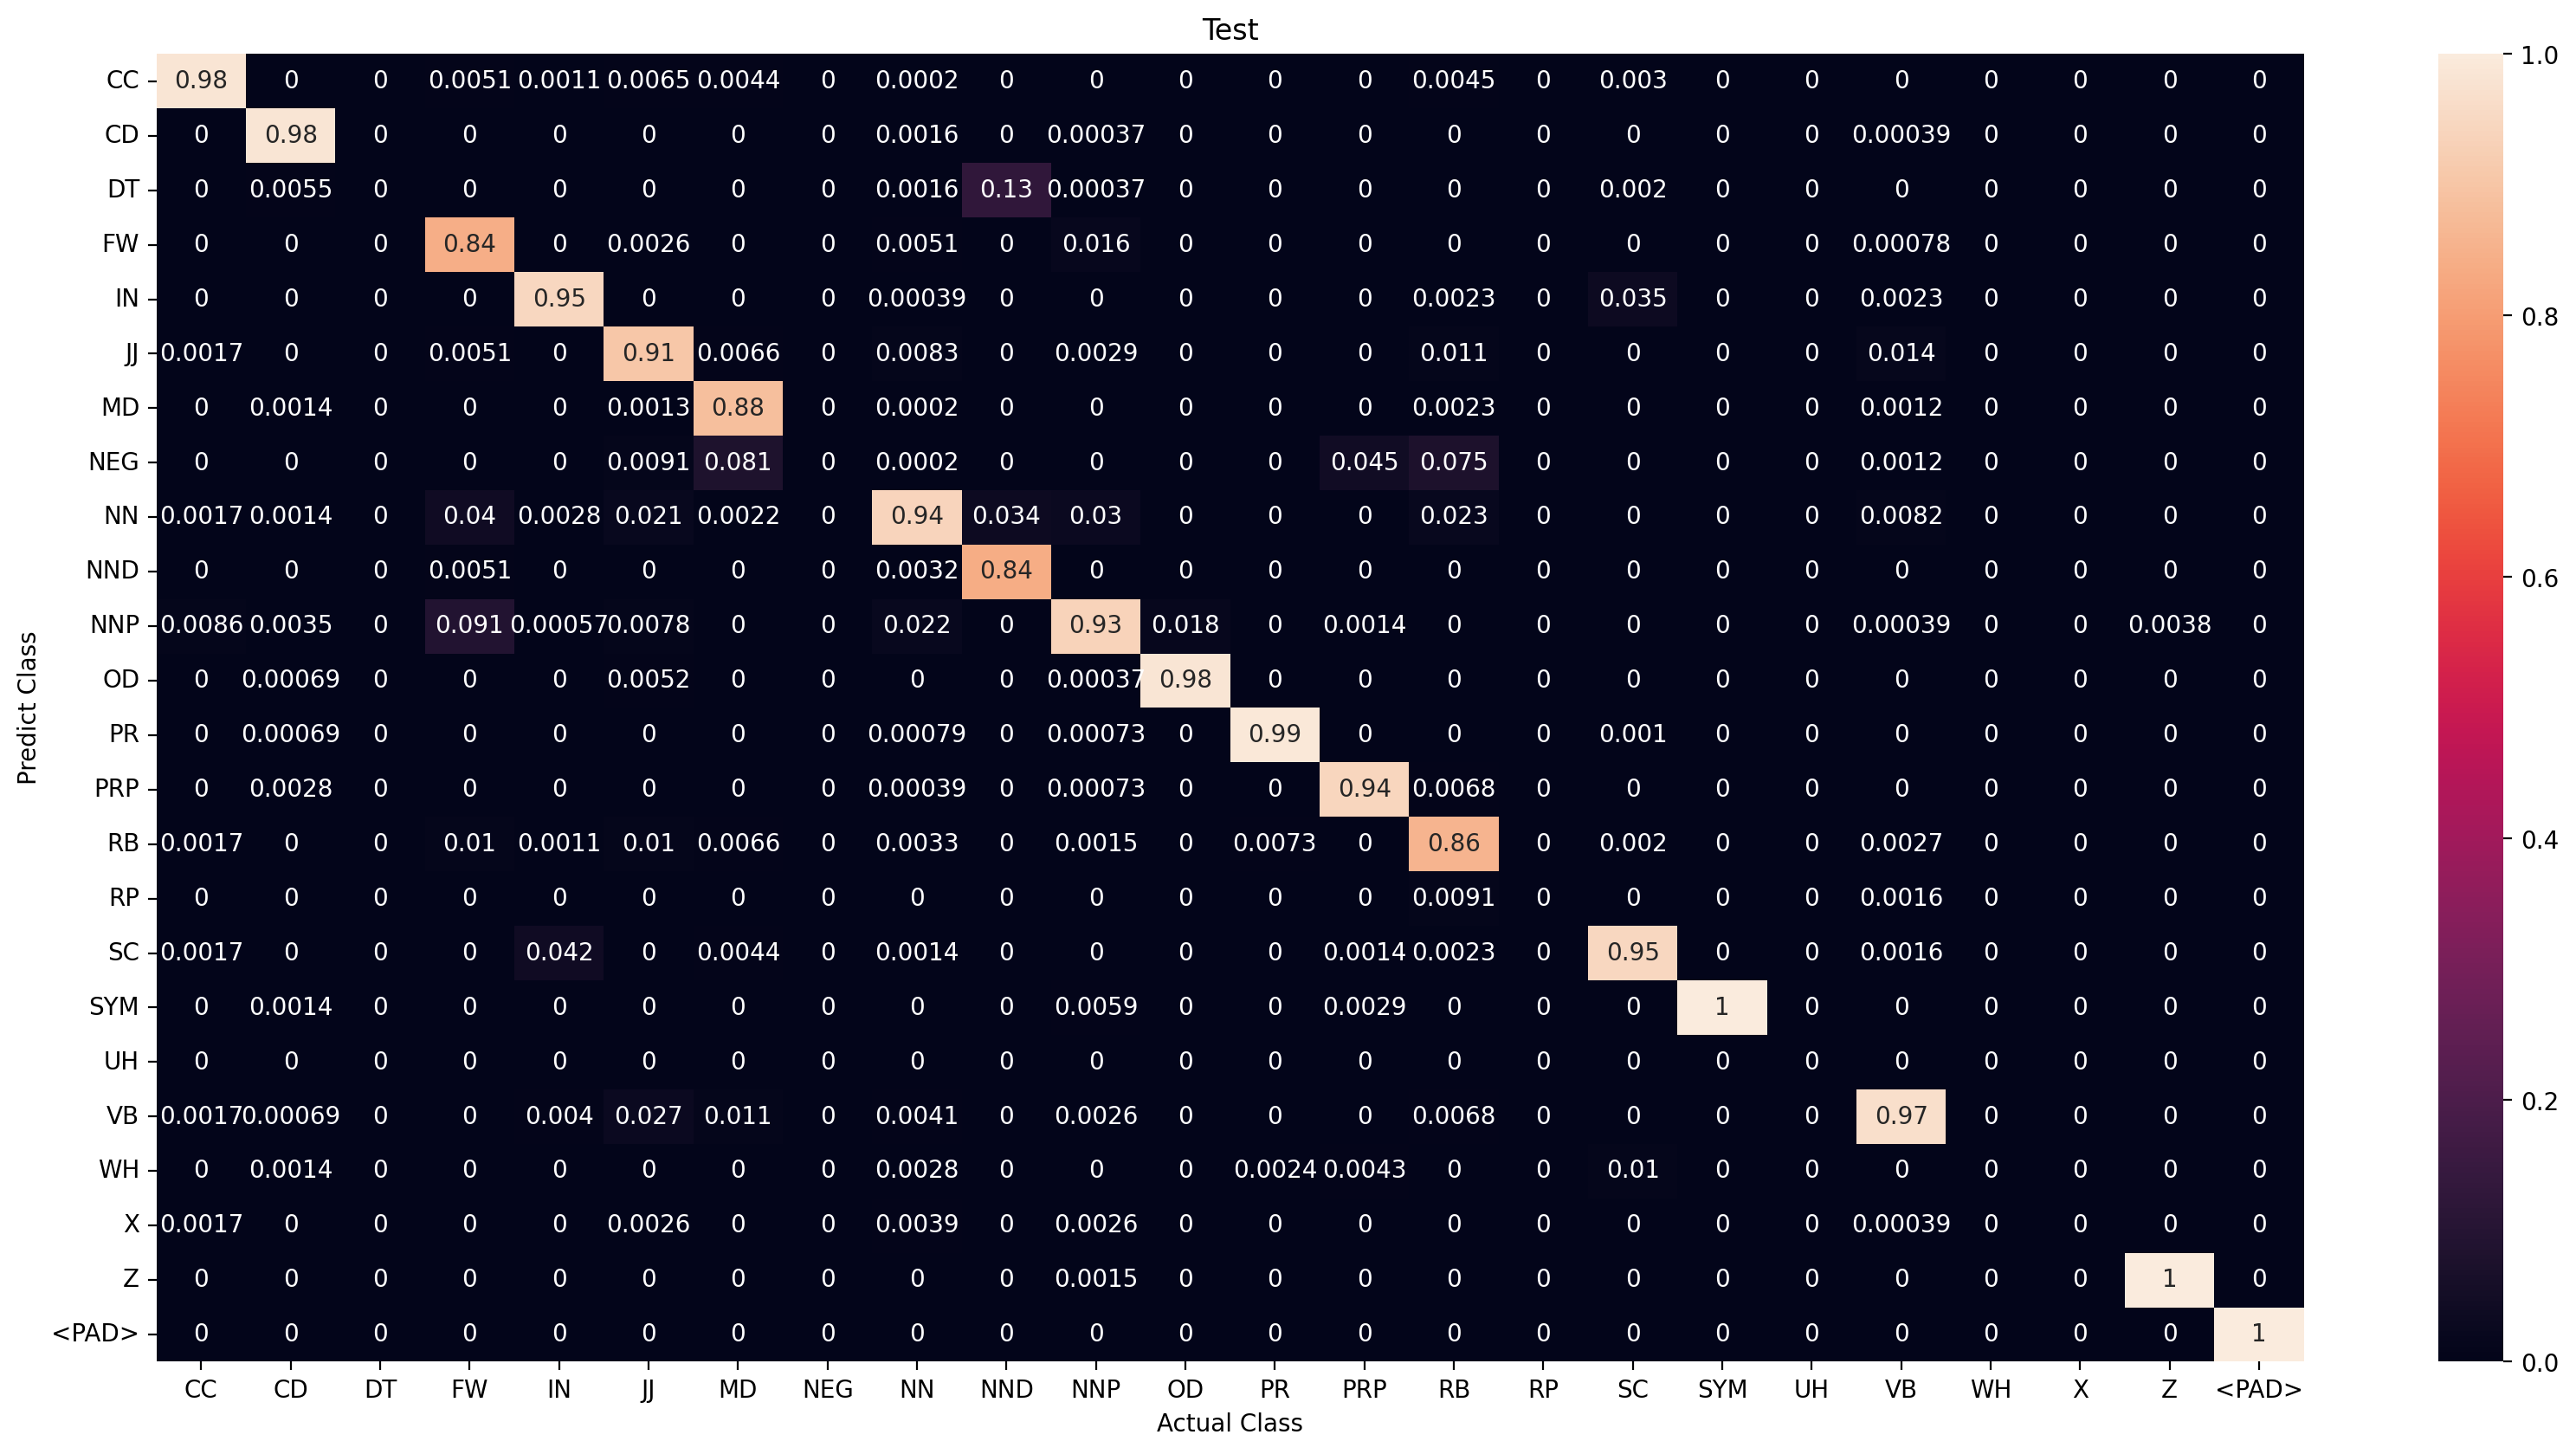

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5201       | CC    : 135      |
| CD    : 12904  | CD    : 12830      | CD    : 74       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1447       | FW    : 250      |
| IN    : 15290  | IN    : 15150      | IN    : 140      |
| JJ    : 7049   | JJ    : 6620       | JJ    : 429      |
| MD    : 3783   | MD    : 3685       | MD    : 98       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44243      | NN    : 526      |
| NND   : 998    | NND   : 895        | NND   : 103      |
| NNP   : 24884  | NNP   : 24354      | NNP   : 530      |
| OD    : 550    | OD    : 528        | OD    : 22       |
| PR    : 3878   | PR    : 3822       | PR    : 56       |
| PRP   : 5355   | PRP   : 5282       | PRP   : 73       |
| RB    : 3517   | RB    : 3307       | RB    : 210      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11210
Wrong prediction            : 724
Percentage correct oov pred : 93.93329981565276

Validation
Number OOV token            : 3261
Correct prediction          : 2920
Wrong prediction            : 341
Percentage correct oov pred : 89.54308494326894

Test
Number OOV token            : 1367
Correct prediction          : 1213
Wrong prediction            : 154
Percentage correct oov pred : 88.73445501097294



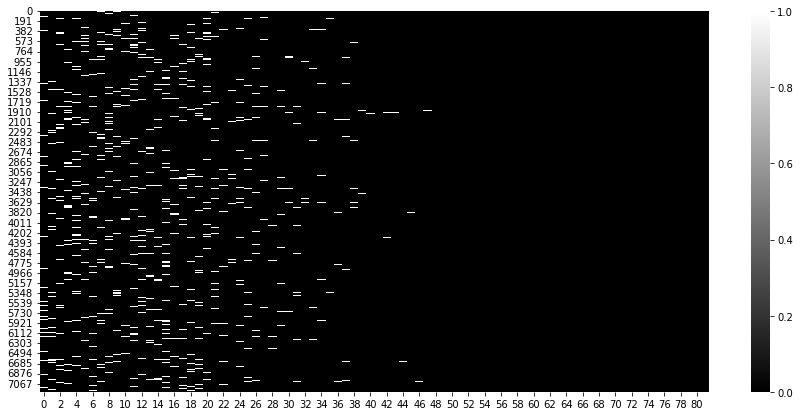

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

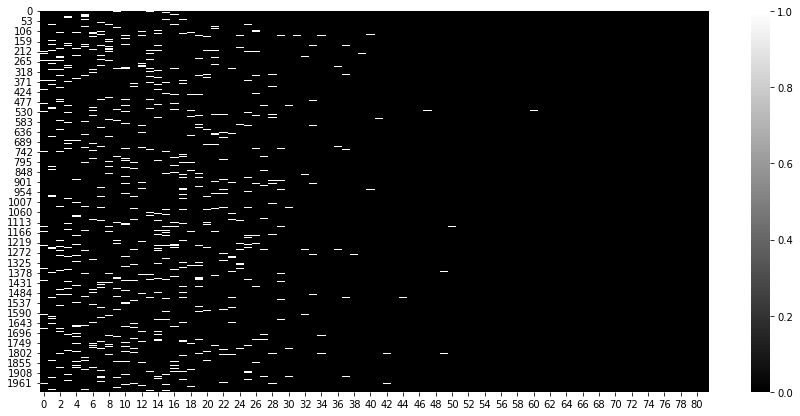

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

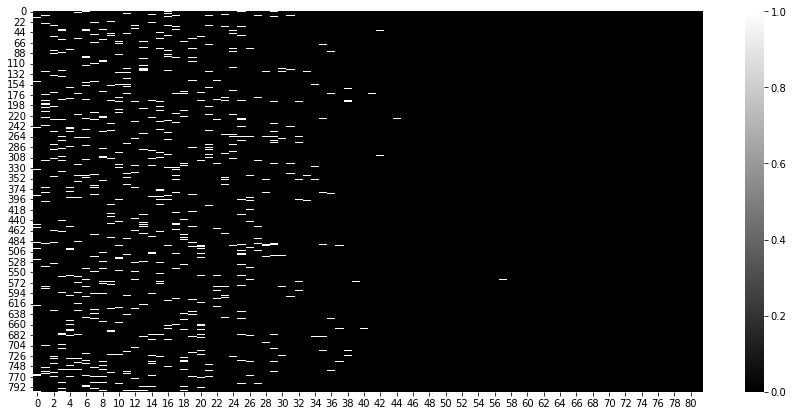

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);